In [1]:
from sklearn.datasets import load_iris
from bokeh.plotting import figure
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colorbar as colorbar
import matplotlib as mpl
from matplotlib.patches import RegularPolygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import seaborn as sns
from minisom import MiniSom 
%matplotlib inline

iris = load_iris()
# DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=['sepal_length','sepal_width','petal_length','petal_width'])
irisDF.head(3)





,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [2]:
#모델 생성 및 시각화에 활용할 데이터프레임
data = irisDF

#데이터셋 확인
data.shape
data.head(10)

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


In [3]:
#각 컬럼의 요약 값 확인
data.describe()




,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [4]:
#표준정규분포를 활용한 Normalization 수행
data = (data-np.mean(data,axis=0))/np.std(data,axis=0)

In [5]:
#데이터셋 확인
data.shape
data.head(5)

,sepal_length,sepal_width,petal_length,petal_width
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444


시작시간: 2023-11-10 01:16:01.056766 


종료시간: 2023-11-10 01:16:37.193613 
총 소요시간: 0 days 00:00:36.136847


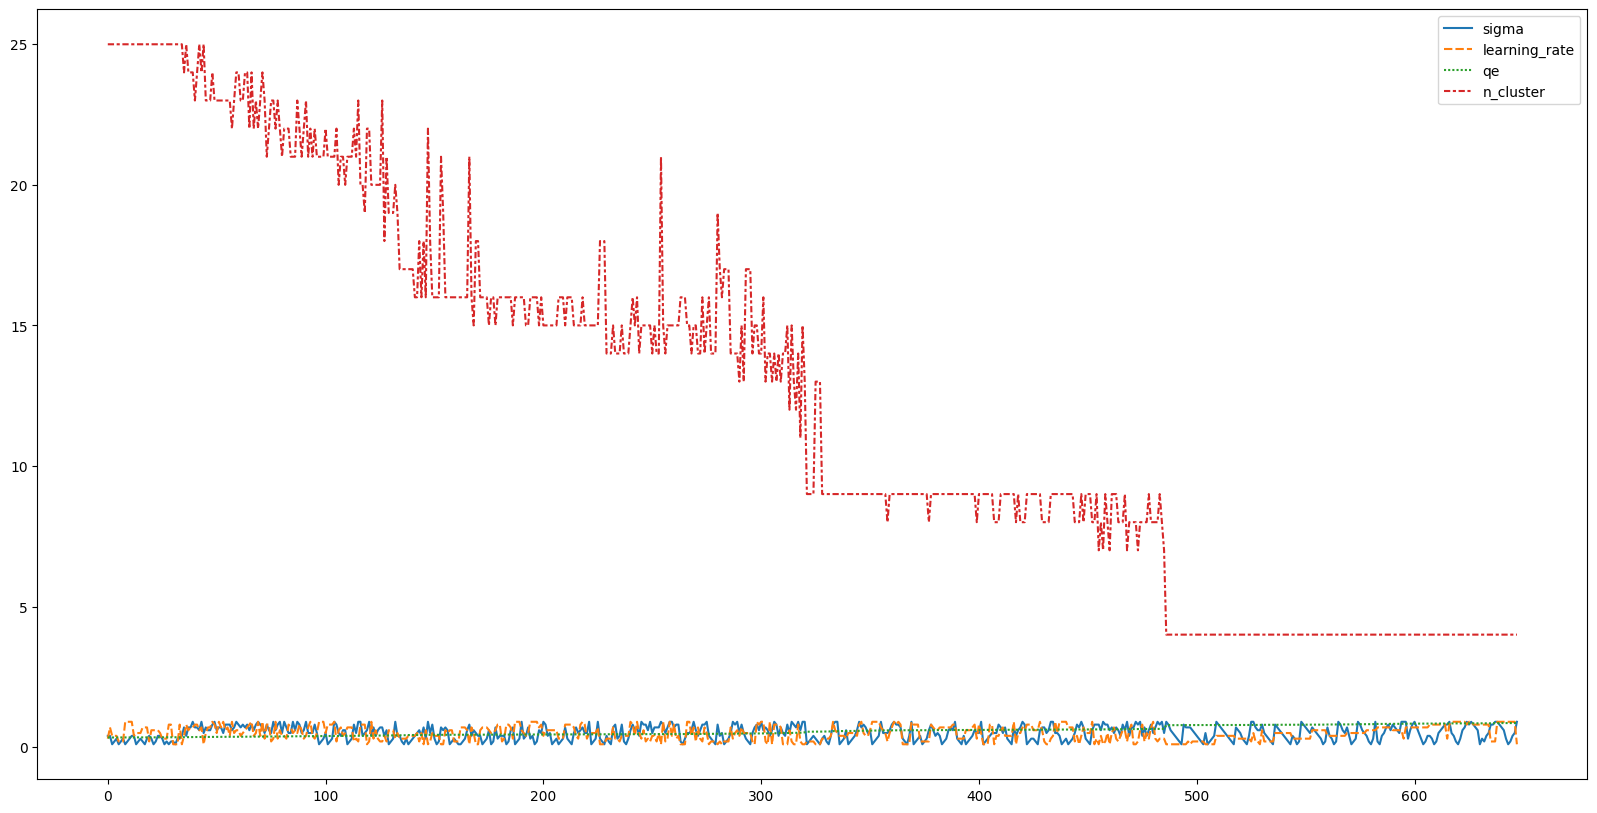

In [6]:
s_time = pd.Timestamp.now()
print('시작시간:',s_time,'\n')

#원하는 파라미터 조합 리스트화
map_n= [n for n in range(2,6)]
para_sigma= [np.round(sigma*0.1,2) for sigma in range(1,10)]
para_learning_rate= [np.round(learning_rate*0.1,2) for learning_rate in range(1,10)]

#결과 값을 담을 리스트 res 생성
res = []
#모든 조합에 대해 모델 생성 및 qe,te값 계산
for n in map_n:
    for sigma in para_sigma:
        for lr in para_learning_rate:
            
            try:
                #랜덤으로 초기값을 설정하는 경우
                estimator = MiniSom(n,n,4,sigma =sigma, learning_rate = lr, topology='hexagonal',random_seed=0)
                estimator.random_weights_init(data.values)
                estimator.train(data.values,1000,random_order=True)
                qe = estimator.quantization_error(data.values)
                #te = estimator.topographic_error(data.values)
                winner_coordinates = np.array([estimator.winner(x) for x in data.values]).T
                cluster_index = np.ravel_multi_index(winner_coordinates,(n,n))
                
                res.append([str(n)+'x'+str(n),sigma,lr,'random_init',qe,len(np.unique(cluster_index))])

                #pca로 초기값을 설정하는 경우
                estimator = MiniSom(n,n,4,sigma =sigma, learning_rate = lr,topology='hexagonal', random_seed=0)
                estimator.pca_weights_init(data.values)
                estimator.train(data.values,1000,random_order=True)
                qe = estimator.quantization_error(data.values)
                #te = estimator.topographic_error(data.values)
                winner_coordinates = np.array([estimator.winner(x) for x in data.values]).T
                cluster_index = np.ravel_multi_index(winner_coordinates,(n,n))
                
                res.append([str(n)+'x'+str(n),sigma,lr,'pca_init',qe,len(np.unique(cluster_index))])
                
            except ValueError as e:
                print(e)
            
#결과 데이터프레임 생성 및 sorting 
df_res = pd.DataFrame(res,columns=['map_size','sigma','learning_rate','init_method','qe','n_cluster']) 
df_res.shape
df_res.sort_values(by=['qe'],ascending=True,inplace=True,ignore_index=True)
df_res.head(10)

#시각화를 위한 lineplot 생성
plt.figure(figsize=(20,10))
sns.lineplot(data = df_res)

e_time = pd.Timestamp.now()
print('\n종료시간:',e_time,'\n총 소요시간:',e_time-s_time)

In [7]:
df_res.head(10)

,map_size,sigma,learning_rate,init_method,qe,n_cluster
0,5x5,0.4,0.3,random_init,0.341474,25
1,5x5,0.4,0.7,random_init,0.342438,25
2,5x5,0.1,0.4,random_init,0.342466,25
3,5x5,0.2,0.4,random_init,0.342466,25
4,5x5,0.3,0.4,random_init,0.342466,25
5,5x5,0.1,0.2,random_init,0.342957,25
6,5x5,0.2,0.2,random_init,0.342957,25
7,5x5,0.3,0.2,random_init,0.342959,25
8,5x5,0.1,0.9,random_init,0.343280,25
9,5x5,0.2,0.9,random_init,0.343280,25


In [8]:
df_res

,map_size,sigma,learning_rate,init_method,qe,n_cluster
0,5x5,0.4,0.3,random_init,0.341474,25
1,5x5,0.4,0.7,random_init,0.342438,25
2,5x5,0.1,0.4,random_init,0.342466,25
3,5x5,0.2,0.4,random_init,0.342466,25
4,5x5,0.3,0.4,random_init,0.342466,25
...,...,...,...,...,...,...
643,2x2,0.1,0.9,pca_init,0.854482,4
644,2x2,0.2,0.9,pca_init,0.854482,4
645,2x2,0.4,0.9,pca_init,0.854482,4
646,2x2,0.5,0.9,pca_init,0.854482,4


In [9]:
## 모델 파라미터 설정
som_b2 = MiniSom(5,5,4,sigma=0.4,learning_rate=0.7,topology='hexagonal',neighborhood_function='gaussian',activation_distance='euclidean', random_seed=0)
#초기값설정
som_b2.pca_weights_init(data.values)
som_b2.train(data.values,1000,random_order=True)

#평가
som_b2.quantization_error(data.values)
#som_b2.topographic_error(data.values)

0.3965730212830505

In [10]:
from matplotlib import colormaps
list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viridis_r',
 'cividis_r',
 'twilight_r',
 'twilight

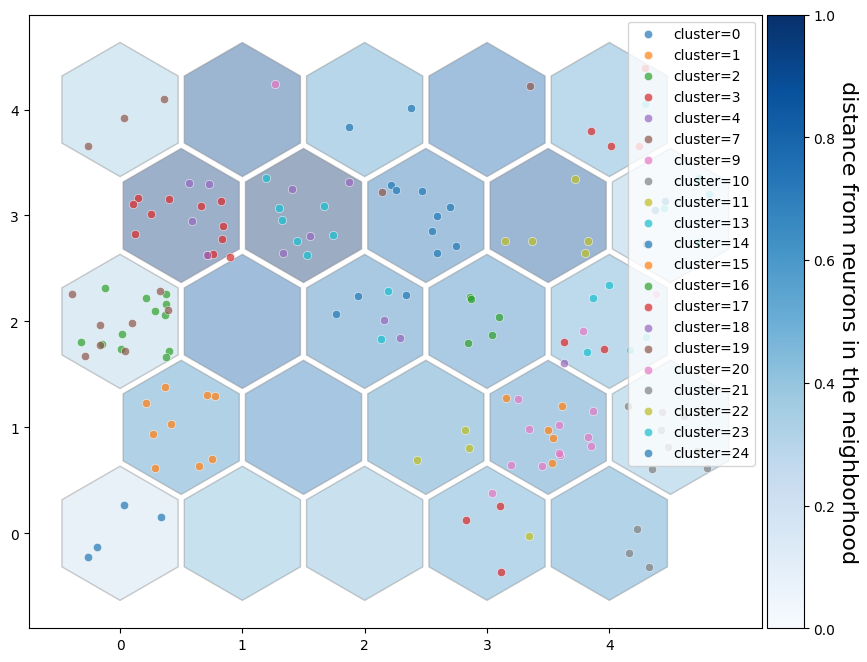

In [11]:
from matplotlib import cm
##
xx, yy = som_b2.get_euclidean_coordinates()
umatrix = som_b2.distance_map()
weights = som_b2.get_weights()

f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)
ax.set_aspect('equal')

# iteratively add hexagons
# plotting the distance map as background
# 해당 셀과 다른 이웃들 간 거리를 표현, 밝을수록 가깝고, 어두울수록 멀다
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * 2 / np.sqrt(3) * 3 / 4
        hex = RegularPolygon((xx[(i, j)], wy), 
                             numVertices=6, 
                             radius=.95 / np.sqrt(3),
                             facecolor=cm.Blues(umatrix[i, j]), 
                             alpha=.4, 
                             edgecolor='gray')
        plot = ax.add_patch(hex)

# output노드에 해당하는 클러스터 종류 및 밀도 확인         
cnt=[]
for c in np.unique(cluster_index):
        x_= [som_b2.convert_map_to_euclidean(som_b2.winner(x))[0] + (2*np.random.rand(1)[0]-1)*0.4 for x in data.values[cluster_index==c]]
        y_= [som_b2.convert_map_to_euclidean(som_b2.winner(x))[1] + (2*np.random.rand(1)[0]-1)*0.4 for x in data.values[cluster_index==c]]
        y_= [(i* 2 / np.sqrt(3) * 3 / 4) for i in y_]
    
        plot = sns.scatterplot( x = x_,  y= y_ ,label='cluster='+str(c),alpha=.7)
        
        #클러스터에 속한 데이터 개수 데이터프레임으로 출력
        cnt.append([c,len(x_)])

#클러스터별 개수를 표 형태로 출력 
df_cnt = pd.DataFrame(cnt,columns=['cluster이름','개수'])
df_cnt

#x축,y축 간격 설정 
xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plot = plt.xticks(xrange-.5, xrange)
plot = plt.yticks(yrange * 2 / np.sqrt(3) * 3 / 4, yrange)

#차트 우측에 color bar생성
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = colorbar.ColorbarBase(ax_cb, cmap=cm.Blues, 
                           orientation='vertical', alpha=.4)
cb1.ax.get_yaxis().labelpad = 16
plot = cb1.ax.set_ylabel('distance from neurons in the neighborhood',
                 rotation=270, fontsize=16)
plot = plt.gcf().add_axes(ax_cb)

#이미지 저장
#plt.savefig('som_seed_hex.png')